In [1]:
import my_package.rectification as rectification
msi_file="/home/llx/project/MSI_data/output_data/V11L12-038_A1_MSI/V11L12-038_A1.Visium.DHB.220826_smamsi.csv"
st_path="/home/llx/project/MSI_data/output_data/V11L12-038_A1_RNA/outs/"
msi_path="/home/llx/project/MSI_data/output_data/V11L12-038_A1_MSI/output_data/V11L12-038_A1_MSI/"
import importlib
import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import SM2ST

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# seed_everything()
seed=2025
rectification.fix_seed(seed)

65 76


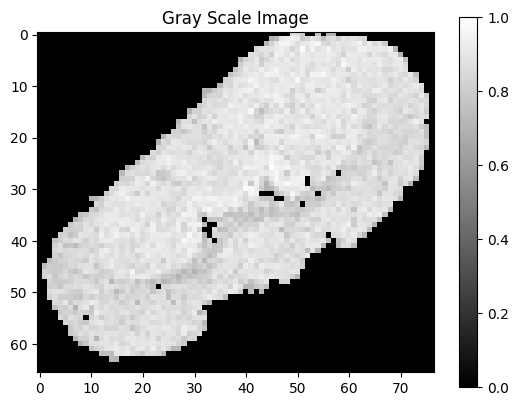

In [3]:
ms_org=pd.read_csv(msi_file)
ms_sp=ms_org.copy()
print(np.max(ms_sp.loc[:,"x"]),np.max(ms_sp.loc[:,"y"]))
ms=rectification.msi_sum(ms_sp,0.7)#0.7
rectification.tensor_viewer(ms)

In [4]:
org_size=ms.shape

In [5]:
org_size

(66, 77)

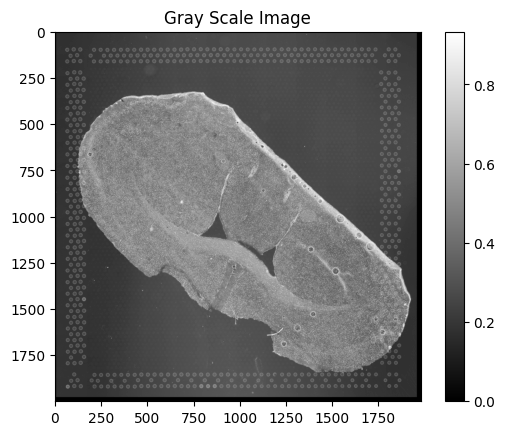

In [6]:
image_path = '/home/llx/project/MSI_data/output_data/V11L12-038_A1_RNA/outs/spatial/tissue_hires_image.png'

normalized_gray_image=rectification.he_img(image_path)
rectification.tensor_viewer(normalized_gray_image)

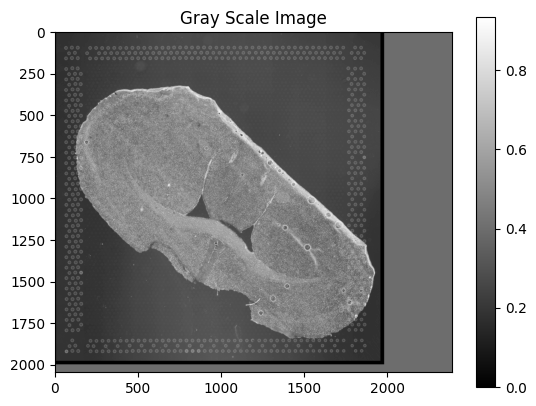

In [7]:
HE_tensor,msi_tensor,rate=rectification.he_padding(ms,normalized_gray_image,0.4)#填充到与MSI等比例
rectification.tensor_viewer(HE_tensor)

In [8]:
target_size=np.array(HE_tensor.shape[2:4])
target_size

array([2046, 2387])

In [9]:
device=torch.device("cuda")

In [10]:
fit_af=rectification.fit(device=device,num_epochs=1000)
fit_af.train_AF(msi_tensor,HE_tensor,list(target_size))#训练

  0%|          | 0/1000 [00:00<?, ?it/s]/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
100%|██████████| 1000/1000 [00:02<00:00, 421.14it/s]


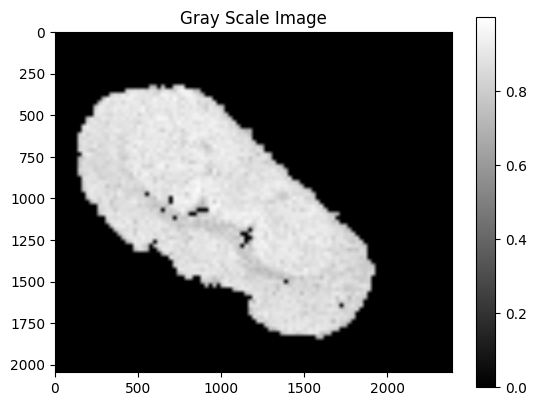

torch.Size([1, 1, 2046, 2387])


In [11]:
af_msi=fit_af.net(msi_tensor.to(device))
rectification.tensor_viewer(af_msi.cpu().detach())
print(af_msi.shape)

In [12]:
af_theta=fit_af.net.theta.squeeze().cpu().detach()
print(af_theta)

tensor([[-1.2994,  0.0000, -0.1773],
        [ 0.0000,  1.2994, -0.1097]])


In [13]:
def torch_af_transfor(af_theta,shape,org_shape,points):

    H, W=org_shape

    points_norm = torch.stack([
        (points[:, 0] / W)*2-1,
        (points[:, 1] / H)*2-1], dim=0).T
    #补齐af
    line3=torch.tensor([[0,0,1]],dtype=torch.float32)
    al_3=torch.cat([af_theta,line3],dim=0)
    af_norm=torch.inverse(al_3)
    #补齐点
    ones=torch.ones(points_norm.shape[0],1)
    points_norm=torch.cat([points_norm,ones],dim=1)
    points_norm=points_norm.T
    print(points_norm.shape)
    print(af_norm.shape)
    points_norm=torch.mm(af_norm,points_norm).T

    print(points_norm)
    H_prime, W_prime = shape

    transformed_points = torch.stack([
        (points_norm[:, 0]+1)/2 * W_prime,
        (points_norm[:, 1]+1)/2 * H_prime
    ], dim=0)

    return transformed_points.T

In [14]:
ms_org_x_y = torch.tensor(np.array(ms_sp.loc[:,["y","x"]]),dtype=torch.float32)

ms_he = torch_af_transfor(af_theta,target_size,org_size,ms_org_x_y)

ms_he

torch.Size([3, 5082])
torch.Size([3, 3])
tensor([[ 0.6332, -0.6852,  1.0000],
        [ 0.6132, -0.6852,  1.0000],
        [ 0.5932, -0.6852,  1.0000],
        ...,
        [-0.8460,  0.8306,  1.0000],
        [-0.8660,  0.8306,  1.0000],
        [-0.8860,  0.8306,  1.0000]])


tensor([[1949.1686,  322.0590],
        [1925.3120,  322.0590],
        [1901.4554,  322.0590],
        ...,
        [ 183.7843, 1872.7344],
        [ 159.9278, 1872.7344],
        [ 136.0712, 1872.7344]])

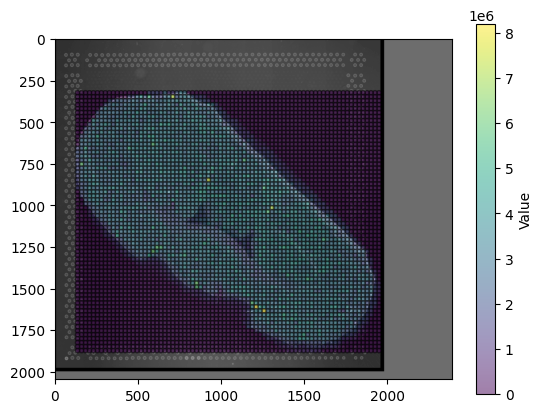

In [15]:
ms_sp.loc[:,["he_x","he_y"]]=ms_he.numpy()
plt.imshow(HE_tensor.squeeze().detach().cpu(), cmap='gray')
scatter = plt.scatter(ms_sp['he_x'], 
                    ms_sp['he_y'], 
                    c=ms_sp['132.07691'], 
                    cmap='viridis', 
                    s=10,
                    alpha=0.5,
                    edgecolor='k')

plt.colorbar(scatter, label='Value')

In [16]:
ms_sp

x   y  130.05041  132.07691  132.077165  133.074345  133.08065  \
0      0   0        0.0        0.0         0.0         0.0        0.0   
1      0   1        0.0        0.0         0.0         0.0        0.0   
2      0   2        0.0        0.0         0.0         0.0        0.0   
3      0   3        0.0        0.0         0.0         0.0        0.0   
4      0   4        0.0        0.0         0.0         0.0        0.0   
...   ..  ..        ...        ...         ...         ...        ...   
5077  65  72        0.0        0.0         0.0         0.0        0.0   
5078  65  73        0.0        0.0         0.0         0.0        0.0   
5079  65  74        0.0        0.0         0.0         0.0        0.0   
5080  65  75        0.0        0.0         0.0         0.0        0.0   
5081  65  76        0.0        0.0         0.0         0.0        0.0   

      136.01592  136.048655  136.06234  ...  986.58098  989.5183649999999  \
0           0.0         0.0        0.0  ...        0.0                0.0   
1           0.0         0.0        0.0  ...        0.0                0.0   
2           0.0         0.0        0.0  ...        0.0                0.0   
3           0.0         0.0        0.0  ...        0.0                0.0   
4           0.0         0.0        0.0  ...        0.0                0.0   
...         ...         ...        ...  ...        ...                ...   
5077        0.0         0.0        0.0  ...        0.0                0.0   
5078        0.0         0.0        0.0  ...        0.0                0.0   
5079        0.0         0.0        0.0  ...        0.0                0.0   
5080        0.0         0.0        0.0  ...        0.0                0.0   
5081        0.0         0.0        0.0  ...        0.0                0.0   

      990.4988149999999  991.50214  992.560465  992.614545  994.56201  \
0                   0.0        0.0         0.0         0.0        0.0   
1                   0.0        0.0         0.0         0.0        0.0   
2                   0.0        0.0         0.0         0.0        0.0   
3                   0.0        0.0         0.0         0.0        0.0   
4                   0.0        0.0         0.0         0.0        0.0   
...                 ...        ...         ...         ...        ...   
5077                0.0        0.0         0.0         0.0        0.0   
5078                0.0        0.0         0.0         0.0        0.0   
5079                0.0        0.0         0.0         0.0        0.0   
5080                0.0        0.0         0.0         0.0        0.0   
5081                0.0        0.0         0.0         0.0        0.0   

      996.51046         he_x         he_y  
0           0.0  1949.168579   322.059021  
1           0.0  1925.312012   322.059021  
2           0.0  1901.455444   322.059021  
3           0.0  1877.598877   322.059021  
4           0.0  1853.742554   322.059021  
...         ...          ...          ...  
5077        0.0   231.497391  1872.734375  
5078        0.0   207.640854  1872.734375  
5079        0.0   183.784332  1872.734375  
5080        0.0   159.927795  1872.734375  
5081        0.0   136.071198  1872.734375  

[5082 rows x 2758 columns]

In [17]:
# from scipy.sparse import csr_matrix, csc_matrix, coo_matrix

# spot=[f"mspx_{i}" for i in range(len(ms_org))]
# ms_name=[f"{i}" for i in ms_org.iloc[:,2:].columns]

# ms_cons=pd.concat([pd.Series(spot),ms_sp.loc[:,["he_x","he_y"]],ms_org],axis=1)

In [18]:
# # 计算每一行的总和（从第3列开始）
# row_sums = ms_cons.iloc[:, 5:].sum(axis=1)

# # 删除总和为0的行
# ms_n = ms_cons[row_sums >= 1e6]
# ms_n.iloc[:, 5:] = ms_n.iloc[:, 5:].apply(lambda x: x - x.min(), axis=0)
# ms_intensity = csr_matrix(ms_n.iloc[:,5:], dtype=np.float32)
# print(ms_intensity.shape)
# ms_adata = ad.AnnData(ms_intensity)
# ms_adata.var_names=ms_n.iloc[:,5:].columns
# ms_adata.obs_names=ms_n.iloc[:,0]
# ms_n.index = ms_n.iloc[:,0]
# ms_adata.obs["array_row"]=ms_n.iloc[:,3] ##raw x
# ms_adata.obs["array_col"]=ms_n.iloc[:,4] ##raw y
# ms_adata.obsm["spatial"]=ms_n.loc[:,["he_x","he_y"]].to_numpy()
# from PIL import Image
# image_path = '/home/llx/project/MSI_data/output_data/V11L12-038_A1_RNA/outs/spatial/tissue_hires_image.png'
# image = Image.open(image_path)
# image_array = np.array(image)
# spatial_key = "spatial"
# library_id = "tissue42"  # 你可以自定义这个 ID
# ms_adata.uns[spatial_key] = {library_id: {}}
# ms_adata.uns[spatial_key][library_id]["images"] = {"hires": image_array}
# ms_adata.uns[spatial_key][library_id]["scalefactors"] = {
#     "tissue_hires_scalef": 1,  # 图像像素和空间坐标的比例因子
#     "spot_diameterres_full": 0.5,  # 每个观测点的直径
#     'fiducial_diameter_fullres': 609.8565193216596,
#     'spot_diameter_fullres': 377.5302262467417
# }

In [19]:
ms_adata = SM2ST.ms2anndata(ms_org = ms_org,ms_sp = ms_sp,HE_path = image_path,in_tissue=True)

In [20]:
import scanpy as sc
st_adata=sc.read_visium(st_path,
               count_file='filtered_feature_bc_matrix.h5',
               source_image_path="tissue_hires_image.png")
st_adata

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2856 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [82]:
st_adata.uns['spatial']['V11L12-038_A1']['scalefactors']['tissue_hires_scalef']

0.04155585

In [21]:
st_adata.uns['spatial']['V11L12-038_A1']['scalefactors']['tissue_lowres_scalef']/st_adata.uns['spatial']['V11L12-038_A1']['scalefactors']['tissue_hires_scalef']

0.30000002406400067

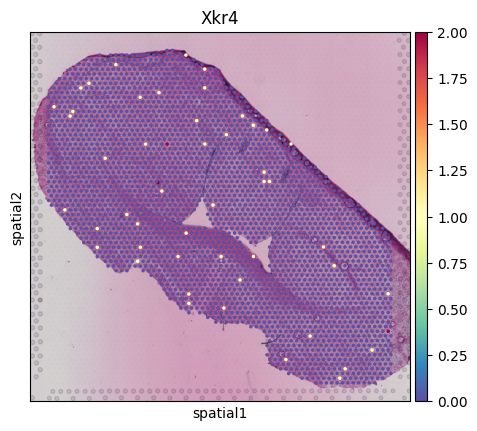

In [22]:
sc.pl.spatial(st_adata, 
              img_key="hires", 
              color=['Xkr4'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=1,
              spot_size=None,
              bw=False, 
              alpha_img=1)#color是一个感兴趣的基因的list

In [23]:
sc.pp.highly_variable_genes(st_adata, flavor="seurat_v3", n_top_genes=3000)

In [24]:
st_adata.var[st_adata.var['variances_norm']>1]

gene_ids    feature_types genome  highly_variable  \
Sox17           ENSMUSG00000025902  Gene Expression   mm10            False   
Gm37587         ENSMUSG00000104238  Gene Expression   mm10            False   
Lypla1          ENSMUSG00000025903  Gene Expression   mm10            False   
Oprk1           ENSMUSG00000025905  Gene Expression   mm10             True   
Npbwr1          ENSMUSG00000033774  Gene Expression   mm10            False   
...                            ...              ...    ...              ...   
mt-Nd4          ENSMUSG00000064363  Gene Expression   mm10             True   
mt-Nd6          ENSMUSG00000064368  Gene Expression   mm10            False   
mt-Cytb         ENSMUSG00000064370  Gene Expression   mm10             True   
CAAA01118383.1  ENSMUSG00000063897  Gene Expression   mm10            False   
CAAA01147332.1  ENSMUSG00000095742  Gene Expression   mm10            False   

                highly_variable_rank      means    variances  variances_norm  
Sox17                            NaN   0.014356     0.016256        1.037171  
Gm37587                          NaN   0.000350     0.000350        1.000455  
Lypla1                           NaN   0.125000     0.147242        1.015561  
Oprk1                          876.0   0.092437     0.128755        1.221796  
Npbwr1                           NaN   0.005952     0.006620        1.041063  
...                              ...        ...          ...             ...  
mt-Nd4                          25.0  20.542017  1255.364959        3.437275  
mt-Nd6                           NaN   0.120098     0.140037        1.007846  
mt-Cytb                         18.0  27.057073  2512.731943        3.876441  
CAAA01118383.1                   NaN   0.035714     0.041456        1.048620  
CAAA01147332.1                   NaN   0.000350     0.000350        1.000455  

[7168 rows x 8 columns]

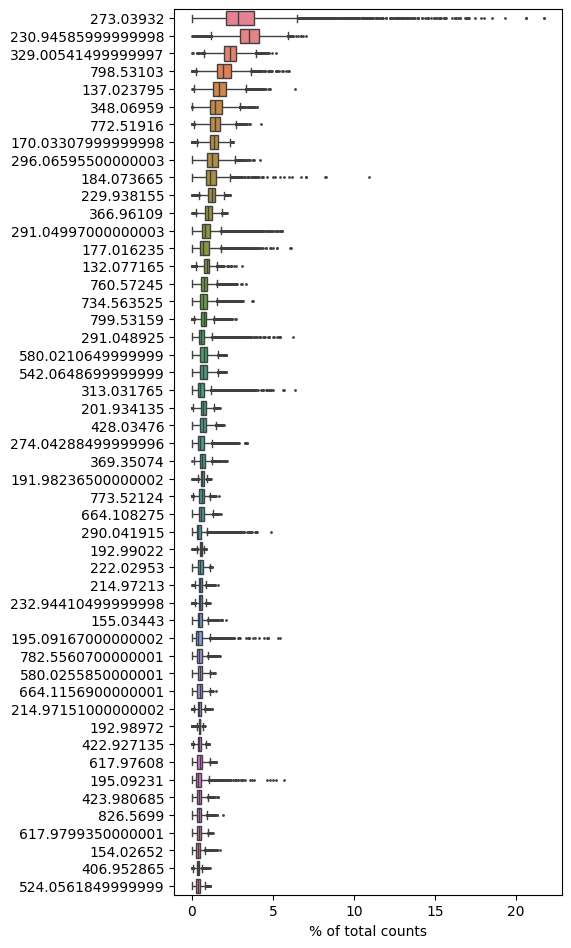

In [25]:
sc.pl.highest_expr_genes(ms_adata, n_top=50, )

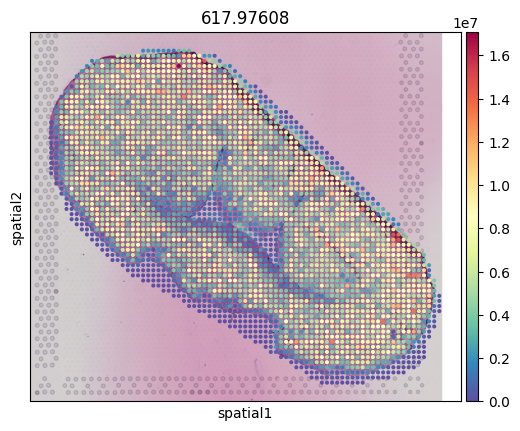

In [26]:
sc.pl.spatial(ms_adata, 
              img_key="hires", 
              color=['617.97608'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=0.05,
              spot_size=None,
              bw=False, 
              alpha_img=1)#color是一个感兴趣的基因的list


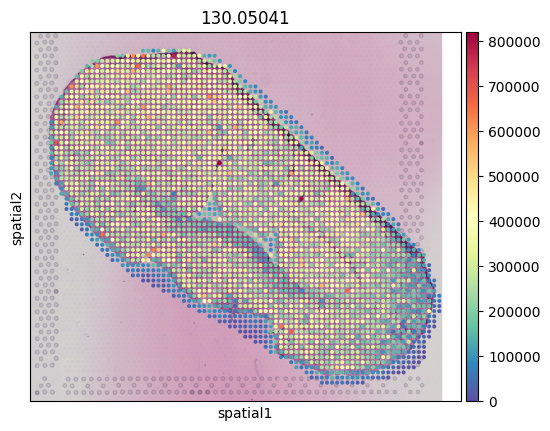

In [27]:
sc.pl.spatial(ms_adata, 
              img_key="hires", 
              color=['130.05041'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=0.05,
              spot_size=None,
              bw=False, 
              alpha_img=1)#color是一个感兴趣的基因的list


In [28]:
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix
from PIL import Image
import anndata as ad

st_intensity = csr_matrix(st_adata.X.A, dtype=np.float32)
print(st_intensity.shape)
st_adata1 = ad.AnnData(st_intensity)
st_adata1.var_names=st_adata.var_names
st_adata1.obs_names=st_adata.obs_names
st_adata1.obs["array_row"]=st_adata.obs["array_row"]##raw x
st_adata1.obs["array_col"]=st_adata.obs["array_col"]##raw y
st_adata1.obsm["spatial"]=st_adata.obsm["spatial"]*st_adata.uns['spatial']['V11L12-038_A1']['scalefactors']['tissue_hires_scalef']
from PIL import Image
image_path = '/home/llx/project/MSI_data/output_data/V11L12-038_A1_RNA/outs/spatial/tissue_hires_image.png'
image = Image.open(image_path)
image_array = np.array(image)
spatial_key = "spatial"
library_id = "V11L12-038_A1"  # 你可以自定义这个 ID
st_adata1.uns[spatial_key] = {library_id: {}}
st_adata1.uns[spatial_key][library_id]["images"] = {"hires": image_array}
st_adata1.uns[spatial_key][library_id]["scalefactors"] = {
    "tissue_hires_scalef": 1,  # 图像像素和空间坐标的比例因子
    "spot_diameterres_full": 0.5,  # 每个观测点的直径
    'fiducial_diameter_fullres': 609.8565193216596,
    'spot_diameter_fullres': 377.5302262467417
}

(2856, 32285)


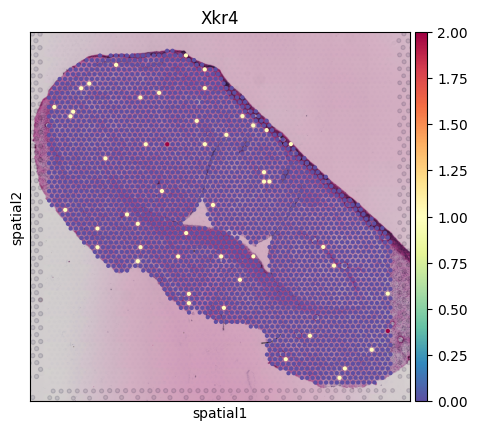

In [29]:
sc.pl.spatial(st_adata1, 
              img_key="hires", 
              color=['Xkr4'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=0.05,
              spot_size=None,
              bw=False, 
              alpha_img=1)#color是一个感兴趣的基因的list

In [30]:
st_adata1.obsm['spatial']

array([[1428.1914528 , 1251.0804201 ],
       [ 305.6848326 , 1105.5518334 ],
       [ 354.055842  , 1189.45309455],
       ...,
       [1125.9973116 ,  852.51826275],
       [ 522.9388164 , 1147.2739068 ],
       [ 811.5857505 ,  348.94447245]])

In [31]:
ms_adata.obsm['spatial']

array([[ 780.19794,  322.05902],
       [ 756.3414 ,  322.05902],
       [ 732.48486,  322.05902],
       ...,
       [1448.1812 , 1872.7344 ],
       [1424.3245 , 1872.7344 ],
       [1400.468  , 1872.7344 ]], dtype=float32)

In [32]:
print(np.max(ms_adata.obsm['spatial'][:,0]),np.max(ms_adata.obsm['spatial'][:,1]))

1949.1686 1872.7344


In [33]:
ms_adata.uns['coord'] = st_adata1.obsm['spatial']

<Axes: title={'center': '130.05041'}, xlabel='spatial1', ylabel='spatial2'>

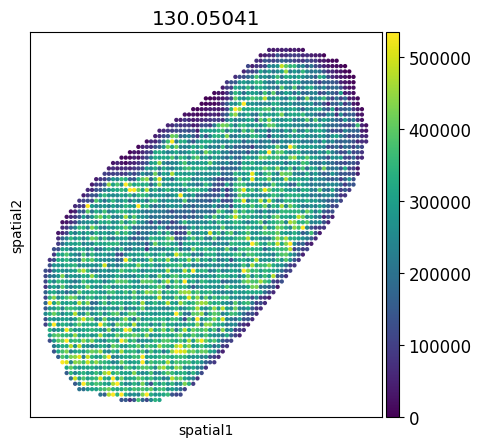

In [34]:
plot_gene = '130.05041'#
fig, ax = plt.subplots(figsize=(5, 5))  # 例如，figsize=(10, 8) 表示宽度为
plt.rcParams['font.size'] = 12  # 假设默认字体大小是10
sc.pl.embedding(ms_adata, basis="spatial", color=plot_gene, show=False,vmax='p99', ax=ax)

In [35]:
# sc.pp.normalize_total(ms_adata, target_sum=1e3)
sc.pp.normalize_total(ms_adata, target_sum=1e4)
sc.pp.log1p(ms_adata)

<Axes: title={'center': '130.05041'}, xlabel='spatial1', ylabel='spatial2'>

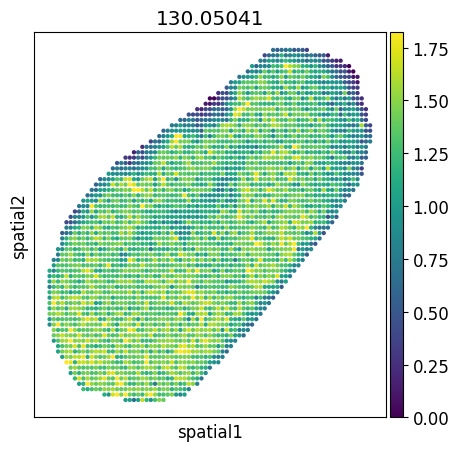

In [36]:
plot_gene = '130.05041'#
fig, ax = plt.subplots(figsize=(5, 5))  # 例如，figsize=(10, 8) 表示宽度为
plt.rcParams['font.size'] = 12  # 假设默认字体大小是10
sc.pl.embedding(ms_adata, basis="spatial", color=plot_gene, show=False,vmax='p99', ax=ax)

In [37]:
ms_adata

AnnData object with n_obs × n_vars = 3105 × 2754
    obs: 'array_row', 'array_col'
    uns: 'spatial', 'coord', 'log1p'
    obsm: 'spatial'

In [38]:
import SM2ST
adata_SMLED = SM2ST.train_SMLED(adata=ms_adata, mask_ratio=0., coord_sf=2.0, train_epoch=15000, experiment='generation',WMMSE = 1.)

Size of Input:  (3105, 2754)
136.07119750976562 322.05902099609375
pixel_step: 48.204785999999785
              0          1
0     14.362298   1.000000
1     13.867398   1.000000
2     13.372499   1.000000
3     12.877597   1.000000
4     12.382698   1.000000
...         ...        ...
3100  29.209296  33.168494
3101  28.714396  33.168494
3102  28.219495  33.168494
3103  27.724593  33.168494
3104  27.229695  33.168494

[3105 rows x 2 columns]               0          1
0     27.804813  20.272389
1      4.518606  17.253424
2      5.522054  18.993941
3     26.559123  25.066355
4     31.056537  18.090493
...         ...        ...
2851  18.277226   8.958596
2852   3.003951   7.671527
2853  21.535847  12.004286
2854   9.025502  18.118941
2855  15.013433   1.557734

[2856 rows x 2 columns]


Epochs: 100%|██████████| 15000/15000 [3:29:54<00:00,  1.19it/s, loss_re: 0.06486, loss_lat: 0.13843, loss_GA: 0.00012, loss: 0.10651, loss_DA: 1.38593]  


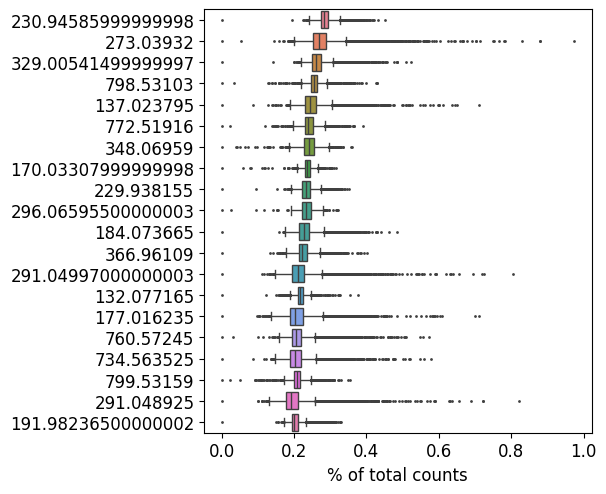

In [39]:
sc.pl.highest_expr_genes(ms_adata, n_top=20, )

<Axes: title={'center': '130.05041'}, xlabel='spatial1', ylabel='spatial2'>

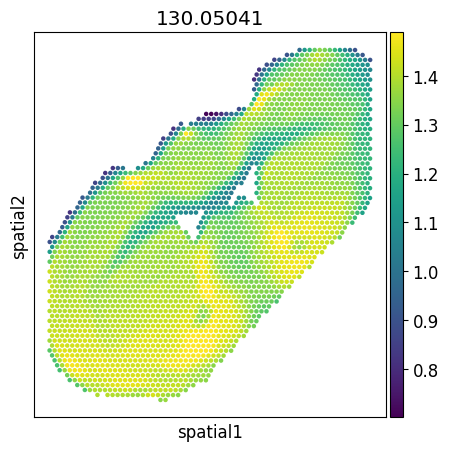

In [40]:
plot_gene = '130.05041'#
fig, ax = plt.subplots(figsize=(5, 5))  # 例如，figsize=(10, 8) 表示宽度为
plt.rcParams['font.size'] = 12  # 假设默认字体大小是10
sc.pl.embedding(adata_SMLED, basis="spatial", color=plot_gene, show=False,vmax='p99', ax=ax)

In [41]:
sc.pp.highly_variable_genes(ms_adata, flavor="seurat_v3", n_top_genes=1000)

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [42]:
ms_adata.var[ms_adata.var['variances_norm']>1]

highly_variable  highly_variable_rank     means  variances  \
136.06234                     True                 383.0  2.373763   0.316682   
146.1181                      True                 959.0  1.090566   0.126946   
146.16571                     True                 199.0  1.744245   0.298747   
146.982305                    True                 611.0  0.632364   0.105109   
147.076965                   False                   NaN  3.076664   0.239147   
...                            ...                   ...       ...        ...   
990.4988149999999             True                 977.0  0.509476   0.085743   
992.560465                    True                 520.0  0.365060   0.098219   
992.614545                    True                 415.0  0.432741   0.108126   
994.56201                    False                   NaN  0.041651   0.017483   
996.51046                    False                   NaN  0.044503   0.018131   

                   variances_norm  
136.06234                1.528347  
146.1181                 1.160517  
146.16571                1.821105  
146.982305               1.343726  
147.076965               1.026982  
...                           ...  
990.4988149999999        1.154461  
992.560465               1.406402  
992.614545               1.491178  
994.56201                1.044150  
996.51046                1.015393  

[1423 rows x 5 columns]

In [64]:
# adata_SMLED.write_h5ad('/home/llx/project/jupyternotebook/1_pyg_backup/SMLED_pyG_result/adata_SMLED_20.h5ad')

In [46]:
adata_SMLED = sc.read_h5ad('/home/llx/project/jupyternotebook/1_pyg_backup/SMLED_pyG_result/adata_SMLED_20.h5ad')

In [43]:
from PIL import Image
image_path = '/home/llx/project/MSI_data/output_data/V11L12-038_A1_RNA/outs/spatial/tissue_hires_image.png'
image = Image.open(image_path)
image_array = np.array(image)
spatial_key = "spatial"
library_id = "tV11L12-038_A1_c"  # 你可以自定义这个 ID
adata_SMLED.uns[spatial_key] = {library_id: {}}
adata_SMLED.uns[spatial_key][library_id]["images"] = {"hires": image_array}
adata_SMLED.uns[spatial_key][library_id]["scalefactors"] = {
    "tissue_hires_scalef": 1,  # 图像像素和空间坐标的比例因子
    "spot_diameterres_full": 0.5,  # 每个观测点的直径
    'fiducial_diameter_fullres': 609.8565193216596,
    'spot_diameter_fullres': 377.5302262467417
}

In [44]:
import squidpy as sq
sq.gr.spatial_neighbors(adata_SMLED)
sq.gr.spatial_autocorr(adata_SMLED, mode="moran", genes=adata_SMLED.var_names)
sq.gr.spatial_autocorr(adata_SMLED, mode="geary", genes=adata_SMLED.var_names)

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/metrics/_gearys_c.py:295: UserWarning: 755 variables were constant, will return nan for these.
  warnings.warn(
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/metrics/_gearys_c.py:295: UserWarning: 755 variables were constant, will return nan for these.
  warnings.warn(


In [45]:
import squidpy as sq
sq.gr.spatial_neighbors(ms_adata)
sq.gr.spatial_autocorr(ms_adata, mode="moran", genes=ms_adata.var_names)
sq.gr.spatial_autocorr(ms_adata, mode="geary", genes=ms_adata.var_names)

In [46]:
ms_adata_high_moran_genes = ms_adata.uns['moranI']['I'][(ms_adata.uns['moranI']['I'] > 0.5) & (ms_adata.uns['moranI']['pval_norm'] < 0.05)].index.tolist()
ms_adata_high_moran = ms_adata[:, ms_adata_high_moran_genes]

ms_adata_high_geary_genes = ms_adata.uns['gearyC']['C'][(ms_adata.uns['gearyC']['C'] < 0.5) & (ms_adata.uns['gearyC']['pval_norm'] < 0.05)].index.tolist()
ms_adata_high_geary = ms_adata[:, ms_adata_high_geary_genes]

In [47]:
adata_SMLED_high_moran_genes = adata_SMLED.uns['moranI']['I'][(adata_SMLED.uns['moranI']['I'] > 0.5) & (adata_SMLED.uns['moranI']['pval_norm'] < 0.05)].index.tolist()
adata_SMLED_high_moran = adata_SMLED[:, adata_SMLED_high_moran_genes]

adata_SMLED_high_geary_genes = adata_SMLED.uns['gearyC']['C'][(adata_SMLED.uns['gearyC']['C'] < 0.5) & (adata_SMLED.uns['gearyC']['pval_norm'] < 0.05)].index.tolist()
adata_SMLED_high_geary = adata_SMLED[:, adata_SMLED_high_geary_genes]

In [48]:
ms_adata_set1 = set(ms_adata_high_geary.var_names)
ms_adata_set2 = set(ms_adata_high_moran.var_names)
ms_adata_v = ms_adata_set1&ms_adata_set2

In [49]:
len(ms_adata_v)

781

In [50]:
adata_SMLED_set1 = set(adata_SMLED_high_geary.var_names)
adata_SMLED_set2 = set(adata_SMLED_high_moran.var_names)
adata_SMLED_v = adata_SMLED_set1&adata_SMLED_set2

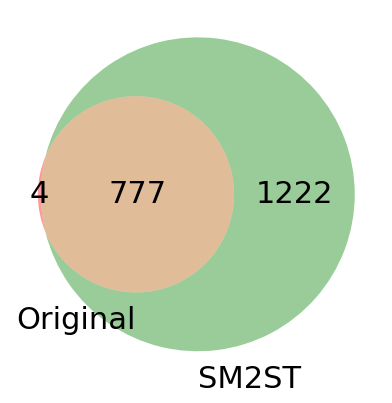

In [62]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# 定义两个集合
set1 = ms_adata_v
set2 = adata_SMLED_v

# 绘制韦恩图
venn = venn2([set1, set2], ('Original', 'SM2ST'))

# 设置标签显示交集和差集的数目
venn.get_label_by_id('100').set_text(f'{len(set1 - set2)}')
venn.get_label_by_id('010').set_text(f'{len(set2 - set1)}')
venn.get_label_by_id('110').set_text(f'{len(set1 & set2)}')
venn.get_label_by_id('100').set_fontsize(22)
venn.get_label_by_id('010').set_fontsize(22)
venn.get_label_by_id('110').set_fontsize(22)
# 设置集合标签的字体大小
venn.get_label_by_id('A').set_fontsize(22)  # 设置集合1的标签字体大小
venn.get_label_by_id('B').set_fontsize(22)  # 设置集合2的标签字体大小
# 显示图形
plt.show()

In [63]:
set1 - set2

{'332.331045', '368.42439', '774.442595', '793.1819849999999'}

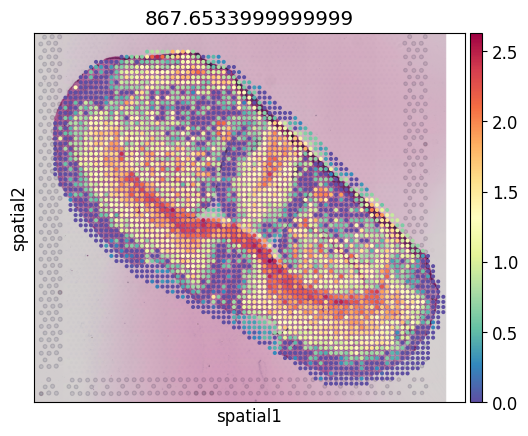

In [64]:
sc.pl.spatial(ms_adata, 
              img_key="hires", 
              color=['867.6533999999999'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=0.05,
              spot_size=None,
              bw=False, 
              alpha_img=1)#color是一个感兴趣的基因的list

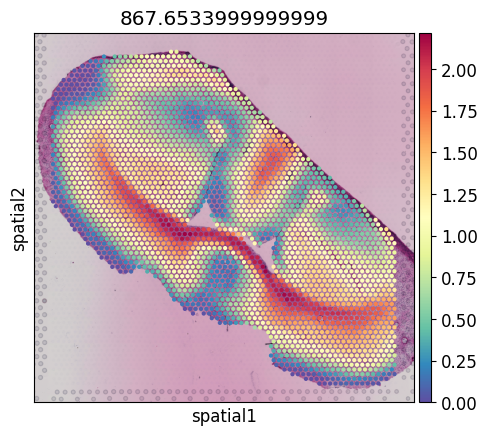

In [65]:
sc.pl.spatial(adata_SMLED, 
              img_key="hires", 
              color=['867.6533999999999'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=0.05,
              spot_size=None,
              bw=False, 
              alpha_img=1)#color是一个感兴趣的基因的list

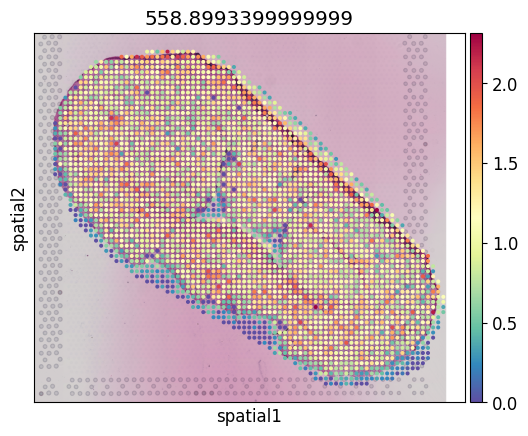

In [66]:
sc.pl.spatial(ms_adata, 
              img_key="hires", 
              color=['558.8993399999999'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=0.05,
              spot_size=None,
              bw=False, 
              alpha_img=1)#color是一个感兴趣的基因的list

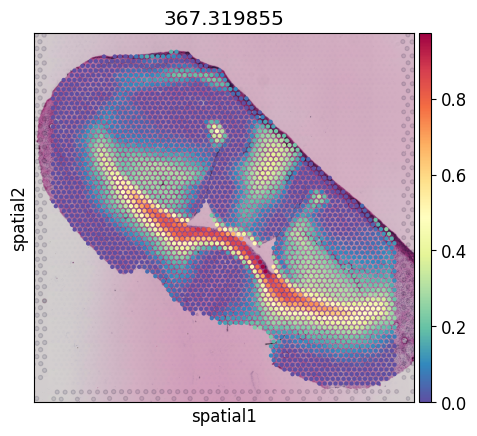

In [67]:
sc.pl.spatial(adata_SMLED, 
              img_key="hires", 
              color=['367.319855'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=0.05,
              spot_size=None,
              bw=False, 
              alpha_img=1)#color是一个感兴趣的基因的list

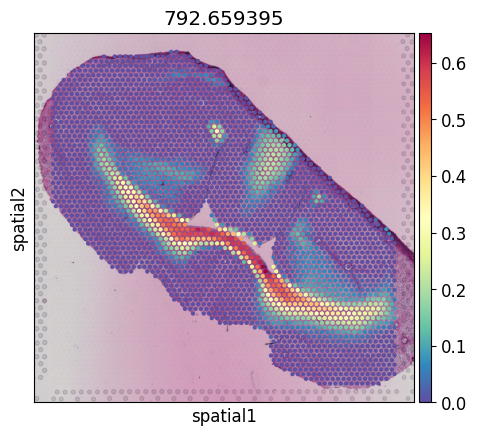

In [68]:
sc.pl.spatial(adata_SMLED, 
              img_key="hires", 
              color=['792.659395'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=0.05,
              spot_size=None,
              bw=False, 
              alpha_img=1)#color是一个感兴趣的基因的list

In [69]:
# ms_adata挑选这些基因set1 & set2
ms_adata_va = ms_adata[:,list(ms_adata_v)]
adata_SMLED_va = adata_SMLED[:,list(ms_adata_v)]

In [70]:
ms_column_sums = np.sum(ms_adata_va.X.A, axis=0)
# 除以行总数（m）
ms_m = ms_adata.X.A.shape[0]
ms_column_means = ms_column_sums / ms_m
SMLED_column_sums = np.sum(adata_SMLED_va.X.A, axis=0)
# 除以行总数（m）
SMLED_m = ms_adata.X.A.shape[0]
SMLED_column_means = SMLED_column_sums / SMLED_m

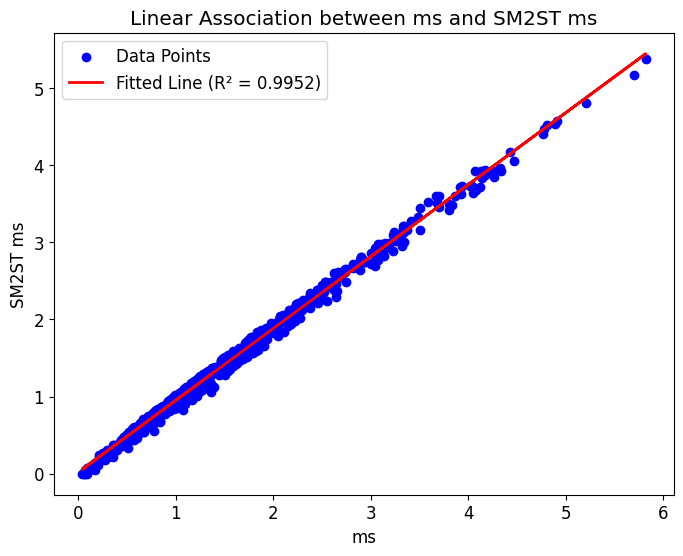

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 假设 ms_column_means 和 SMLED_column_means 是两个 NumPy 数组
# 如果不是 NumPy 数组，可以使用 np.array() 进行转换

# 计算线性回归
X = ms_column_means.reshape(-1, 1)  # 将 ms_column_means 转换为列向量
y = SMLED_column_means

# 创建线性回归模型
model = LinearRegression()
model.fit(X, y)

# 预测值
y_pred = model.predict(X)

# 计算 R² 值
r2 = r2_score(y, y_pred)

# 绘制散点图和拟合曲线
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='blue', label='Data Points')  # 原始数据点
plt.plot(X, y_pred, color='red', linewidth=2, label=f'Fitted Line (R² = {r2:.4f})')  # 拟合曲线
plt.xlabel('ms')
plt.ylabel('SM2ST ms')
plt.title('Linear Association between ms and SM2ST ms')
plt.legend()
# plt.grid(True)
plt.show()